In [14]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations

In [15]:
df = pd.read_csv('data/monthly/24_03.csv')

# Create unique dataframes for start and end stations
start_stations = df[['start_station_id', 'start_station_name', 'start_station_description', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()
end_stations = df[['end_station_id', 'end_station_name', 'end_station_description', 'end_station_latitude', 'end_station_longitude']].drop_duplicates()

# Rename columns for uniformity
start_stations.columns = ['station_id', 'station_name', 'station_description', 'latitude', 'longitude']
end_stations.columns = ['station_id', 'station_name', 'station_description', 'latitude', 'longitude']

# Concatenate the dataframes
stations = pd.concat([start_stations, end_stations]).drop_duplicates()

# Create GeoDataFrame
gdf_stations = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude), crs = 4326
)

In [14]:
gdf_stations.head(5)

,station_id,station_name,station_description,latitude,longitude,geometry
0,615,Munkedamsveien,ved Haakon VIIs gate,59.913523,10.730106,POINT (10.73011 59.91352)
1,444,AHO,langs Maridalsveien,59.925265,10.750462,POINT (10.75046 59.92527)
2,392,Sjøsiden 2 ved fontenen,to rader nærmest fontenen,59.910181,10.751699,POINT (10.75170 59.91018)
3,564,Oscars gate,ved Hegdehaugsveien,59.922422,10.727239,POINT (10.72724 59.92242)
4,421,Alexander Kiellands Plass,langs Maridalsveien,59.928067,10.751203,POINT (10.75120 59.92807)


In [17]:
gdf_stations.explore()

In [27]:
from shapely.geometry import LineString

# Create a new DataFrame with necessary columns
df_rides = df[['start_station_id', 'end_station_id', 'started_at', 'ended_at', 'duration', 'start_station_name', 'start_station_description', 'start_station_latitude', 'start_station_longitude', 'end_station_name', 'end_station_description','end_station_latitude', 'end_station_longitude']]

# Create LineString objects
df_rides['geometry'] = df_rides.apply(lambda row: LineString([(row['start_station_longitude'], row['start_station_latitude']), (row['end_station_longitude'], row['end_station_latitude'])]), axis=1)

# Create GeoDataFrame
gdf_rides = gpd.GeoDataFrame(df_rides, geometry='geometry', crs = 4326)

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_77763/188973286.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides['geometry'] = df_rides.apply(lambda row: LineString([(row['start_station_longitude'], row['start_station_latitude']), (row['end_station_longitude'], row['end_station_latitude'])]), axis=1)


In [28]:
gdf_rides.head(5)

,start_station_id,end_station_id,started_at,ended_at,duration,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_name,end_station_description,end_station_latitude,end_station_longitude,geometry
0,615,452,2024-03-01 04:34:34.497000+00:00,2024-03-01 04:39:41.953000+00:00,307,Munkedamsveien,ved Haakon VIIs gate,59.913523,10.730106,Vippetangen vest,nærmest Rådhuset,59.903989,10.740627,"LINESTRING (10.73011 59.91352, 10.74063 59.90399)"
1,444,526,2024-03-01 04:41:02.793000+00:00,2024-03-01 04:47:58.198000+00:00,415,AHO,langs Maridalsveien,59.925265,10.750462,Lille Grensen,Ved Akersgata,59.913897,10.742310,"LINESTRING (10.75046 59.92527, 10.74231 59.91390)"
2,392,464,2024-03-01 04:45:50.903000+00:00,2024-03-01 04:52:54.592000+00:00,423,Sjøsiden 2 ved fontenen,to rader nærmest fontenen,59.910181,10.751699,Sukkerbiten,ved gangbroen,59.905124,10.753764,"LINESTRING (10.75170 59.91018, 10.75376 59.90512)"
3,564,396,2024-03-01 04:46:58.214000+00:00,2024-03-01 04:53:27.653000+00:00,389,Oscars gate,ved Hegdehaugsveien,59.922422,10.727239,Kirkeristen,ved Torggata,59.913000,10.746761,"LINESTRING (10.72724 59.92242, 10.74676 59.91300)"
4,421,448,2024-03-01 04:56:09.969000+00:00,2024-03-01 05:04:30.171000+00:00,500,Alexander Kiellands Plass,langs Maridalsveien,59.928067,10.751203,Oslo Plaza,ved rundkjøringen,59.912183,10.754434,"LINESTRING (10.75120 59.92807, 10.75443 59.91218)"


In [29]:
gdf_rides.sample(n=50).explore() # sample due to large amount of data

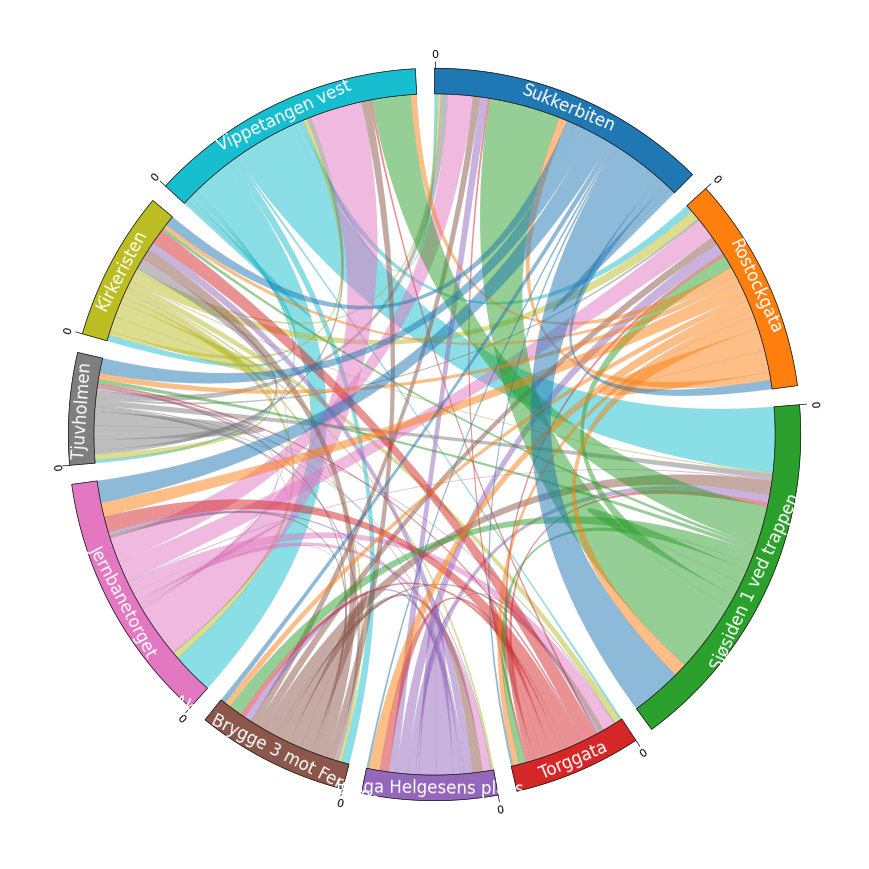

In [42]:
from pycirclize import Circos
import pandas as pd

#  top most frequent stations of gdf_rides
top_gdf_rides = gdf_rides['start_station_name'].value_counts().head(10)
filtered_gdf_rides = gdf_rides[gdf_rides['start_station_name'].isin(top_gdf_rides.index)]

row_names = filtered_gdf_rides['start_station_name'].unique()
col_names = row_names
matrix_data = filtered_gdf_rides.groupby(['start_station_name', 'end_station_name']).size().unstack().fillna(0)
matrix_df = pd.DataFrame(matrix_data, index=row_names, columns=col_names)

# Initialize from matrix (Can also directly load tsv matrix file)
circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    r_lim=(93, 100),
    cmap="tab10",
    ticks_interval=500,
    label_kws=dict(r=94, size=12, color="white"),
)

fig = circos.plotfig()

## Districts

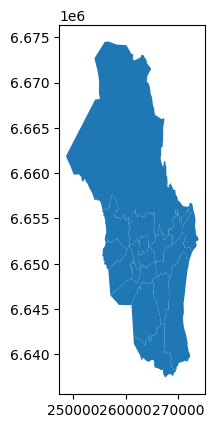

In [27]:
# Load the GeoJSON file
oslo_kommuner_gdf = gpd.read_file('data/Oslo_Kommuner.geojson')

# Plot the GeoDataFrame
oslo_kommuner_gdf.plot()

# Show the plot
plt.show()

In [5]:
oslo_kommuner_gdf.head()

,objtype,identifikasjon.Identifikasjon.lokalId,identifikasjon.Identifikasjon.navnerom,identifikasjon.Identifikasjon.versjonId,oppdateringsdato,gyldigFra,gyldigTil,datafangstdato,kvalitet.Posisjonskvalitet.målemetode,kvalitet.Posisjonskvalitet.nøyaktighet,datauttaksdato,opphav,avgrensningstype,geometry
0,Grense,00084e46-d1f2-33e2-9e45-60217d02ba25,https://data.geonorge.no/sosi/inndelinger/innd...,None,2023-11-07 21:27:04+01:00,20231107,None,NaT,96,200.0,2024-03-04 12:27:10+01:00,Kartverket,Kommunegrense,"LINESTRING (21.62670 69.61539, 21.62239 69.62590)"
1,Grense,0008facf-bfd2-31d5-9a03-d3df2e595dd6,https://data.geonorge.no/sosi/inndelinger/innd...,None,2023-11-07 21:43:30+01:00,20231107,None,NaT,55,200.0,2024-03-04 12:27:11+01:00,Kartverket,Kommunegrense,"LINESTRING (5.70310 58.67751, 5.70312 58.67748..."
2,Grense,001028ad-daeb-3457-b0d6-c7d28a705e12,https://data.geonorge.no/sosi/inndelinger/innd...,None,2023-11-07 22:17:30+01:00,20231107,None,NaT,53,1500.0,2024-03-04 12:27:11+01:00,Kartverket,Kommunegrense,"LINESTRING (28.54985 70.34037, 28.68744 70.342..."
3,Grense,0013634f-6156-3dc6-8e8c-eb64db29075e,https://data.geonorge.no/sosi/inndelinger/innd...,None,2023-11-07 21:53:34+01:00,20231107,None,NaT,55,200.0,2024-03-04 12:27:11+01:00,Kartverket,Kommunegrense,"LINESTRING (11.17024 60.24020, 11.17048 60.240..."
4,Grense,00305c14-d812-3a46-86fb-a5c8c5782a06,https://data.geonorge.no/sosi/inndelinger/innd...,None,2023-11-07 21:41:31+01:00,20231107,None,NaT,55,200.0,2024-03-04 12:27:11+01:00,Kartverket,Fylkesgrense,"LINESTRING (8.57545 58.93144, 8.57557 58.93131..."
